<a href="https://colab.research.google.com/github/camdsDS/Cesar_Portfolio/blob/main/Titanic_from_kaggle_GradientBoostingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Modelo de classificação
#Desafio Kaggle: https://www.kaggle.com/c/titanic
import pandas as pd
import numpy as np

# Funções

In [2]:
#vamos definir uma função que dropa colunas com uma porcentagem de valores miss
#superior a um valor P_miss arbitrário
#P_miss é a menor % tolerada de miss
def DropaMiss(df, P_miss=0):
  df_miss2 = ((df.isna().sum()/len(df))*100).to_frame().rename(columns={0:'P_miss'}).reset_index().sort_values('P_miss', ascending = False)
  df_miss = ((df.isna().sum()/len(df))*100).to_frame().rename(columns={0:'P_miss'}).reset_index()
  df_miss = df_miss[df_miss['P_miss'] <= P_miss]
  df = df[df_miss['index'].to_list()]
  return df,df_miss2

# Calculando a Bad Rate

In [3]:
data = pd.read_csv('train.csv', index_col = 'PassengerId')
data.head()
#Para mais informações sobre o tipo de dado apresentado em cada coluna, visite:
#https://www.kaggle.com/c/titanic/data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
bad_rate = data['Survived'].value_counts()[1]/(data['Survived'].value_counts()[0]+data['Survived'].value_counts()[1])
bad_rate

0.3838383838383838

# Preparando modelo e df de treino 

In [5]:
Titanic_Data_Train = data.copy()

In [6]:
#definindo o alvo
y = Titanic_Data_Train['Survived']

In [7]:
#com exceção da coluna alvo ("Survived") e das colunas
#"Name", "Ticket" e "Cabin", usaremos todas as colunas como features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train = Titanic_Data_Train[features]

#### Dividindo o df treino em dois: dados numéricos e dados categóricos

In [8]:
X_train.dtypes
#Temos apenas 3 tipos de dados: int64, float64 e object. Vamos, a partir deles,
X_train_numericos = X_train.select_dtypes(exclude=['object'])
X_train_categoricos = X_train.select_dtypes('object')

## Tratando os dados da base de treino

#### Procurando por valores inconsistentes

In [9]:
X_train_numericos.Pclass.describe()
X_train_numericos.Age.describe()
X_train_numericos.SibSp.describe()
X_train_numericos.Parch.describe()
X_train_numericos.Fare.describe() #valores 0 para Fare, mas vamos manter
X_train_categoricos.Sex.describe()
X_train_categoricos.Embarked.describe()
#todos os valores estão ok

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

## Tratando miss numerico do train

In [10]:
#usando a função DropaMiss com o df X_train e gerando o relatorio
#'relatorio_miss' vamos dropar, se existirem, colunas com
#mais de 80% de valores miss
X_train_numericos, relatorio_miss_N = DropaMiss(X_train_numericos, 80)
X_train_categoricos, relatorio_miss_C = DropaMiss(X_train_categoricos, 80)

In [11]:
relatorio_miss_N
relatorio_miss_C
#Há apenas duas colunas (Age e Embarked) no df treino com valores miss e
#nenhuma apresenta valor maior do que 80% de miss (logo, a função nada dropou)
#Não parece que o valor miss, nesses casos, signifique algo. Por isso, no caso
#da coluna numérica iremos substituir os dados miss pelo valor médio

,index,P_miss
1,Embarked,0.224467
0,Sex,0.000000


In [12]:
valores_train_numericos = {'Age': X_train_numericos['Age'].mean()}
X_train_numericos = X_train_numericos.fillna(value = valores_train_numericos)

In [13]:
#não iremos tratar os valores miss categorico porque
#iremos usar pandas.get_dummies, que os transforma em 0 0 ... 0.

#### Transformando categóricas em números

In [14]:
X_train_categoricos = pd.get_dummies(X_train_categoricos, drop_first=True)

#### Juntando os df numericos e o categóricos

In [15]:
X_train_tratados = pd.merge(X_train_numericos, X_train_categoricos, how ='left', left_index = True, right_index = True)

#### Normalização dos dados

In [16]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
scaler.fit(X_train_tratados)

abt_train = pd.DataFrame(scaler.transform(X_train_tratados), columns=X_train_tratados.columns)
abt_train.index = X_train.index

# Dividindo Treino em Desenv e Valid

In [17]:
from sklearn.model_selection import train_test_split
X_desenv, X_valid, y_desenv, y_valid = train_test_split(abt_train, y, train_size=0.8, test_size=0.2)

# Montando e treinando o modelo

### Testando 3 modelos: logistic regression, grandientboosting e o randomforest

In [18]:
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

LR = LogisticRegression()
GB = GradientBoostingClassifier()
RF = RandomForestClassifier()

In [19]:
from sklearn.model_selection import cross_validate

teste_modelLR = cross_validate(estimator=LR, X=X_desenv, y=y_desenv, scoring='roc_auc')
teste_modelGB = cross_validate(estimator=GB, X=X_desenv, y=y_desenv, scoring='roc_auc')
teste_modelRF = cross_validate(estimator=RF, X=X_desenv, y=y_desenv, scoring='roc_auc')

In [20]:
resultado = [[teste_modelLR['test_score'].mean(), teste_modelGB['test_score'].mean(), teste_modelRF['test_score'].mean()]]

In [21]:
resultado = pd.DataFrame(resultado)

In [22]:
resultado.rename(index={0:'test_score_mean'}, columns={0:'Logist Regression', 1:'Grandient Boosting', 2:'Random Forest'})

,Logist Regression,Grandient Boosting,Random Forest
test_score_mean,0.864223,0.868967,0.84558


In [23]:
#O modelo que performou melhor foi o GB, então usaremos
#GridSearchCV com ele
model = GB

In [24]:
parametros = {'learning_rate':[0.05, 0.1, 0.5, 1], 
              'n_estimators':[100, 125, 150, 175], 'max_depth':[1,3,5] }

In [25]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = model,        #GBR
                    param_grid = parametros,  
                    scoring = 'roc_auc',      
                    cv = 5)                   #5 folds

In [26]:
# Treinando o grid.
grid.fit(X_desenv, y_desenv)

# Imprimindo as colunas de interesse dos resultados.
pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,rank_test_score,mean_test_score
5,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",1,0.871712
6,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",2,0.871642
14,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",3,0.869979
16,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",4,0.868799
4,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",5,0.868721
7,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",6,0.868528
15,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",7,0.868319
18,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",8,0.867849
17,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",9,0.867794
13,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",10,0.867730


In [27]:
# Imprime os parâmetros que produziram o ".best_score_".
grid.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 125}

### Avaliando se nosso modelo esta overfitado

In [28]:
roc_score_desenv = roc_auc_score(y_desenv, grid.predict_proba(X_desenv)[:,1])
roc_score_valid = roc_auc_score(y_valid, grid.predict_proba(X_valid)[:,1])
print('roc_score_desenv:', roc_score_desenv)
print('roc_score_valid:', roc_score_valid)
#A diferenca é aceitável. O modelo não está overfitado

roc_score_desenv: 0.9370697639490351
roc_score_valid: 0.8473649538866929


### Matriz de confusão

In [29]:
print (pd.crosstab(y_valid, grid.predict(X_valid), rownames=['Real'], colnames=['Predito'],margins=True))

Predito    0   1  All
Real                 
0        103   7  110
1         27  42   69
All      130  49  179


#### Importância de cada variável de nosso modelo


In [30]:
grad = grid.best_estimator_
grad.fit(abt_train,y)
grad.feature_importances_
var_e_imp = pd.DataFrame({'Variaveis':abt_train.columns.tolist(), 'Importancia':grad.feature_importances_.tolist()}).sort_values('Importancia', ascending=False).reset_index(drop=True)
var_e_imp

,Variaveis,Importancia
0,Sex_male,0.505896
1,Pclass,0.157356
2,Fare,0.147195
3,Age,0.111844
4,SibSp,0.057395
5,Embarked_S,0.017513
6,Embarked_Q,0.002216
7,Parch,0.000585


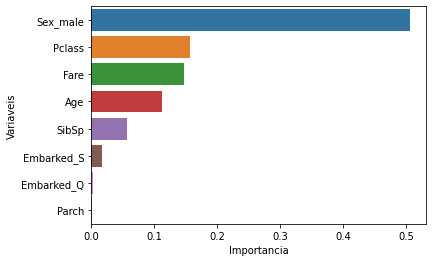

In [31]:
import seaborn as sns

sns.barplot(x=var_e_imp.Importancia, y=var_e_imp.Variaveis)

# Preparando a base de test

In [32]:
#recebendo os dados do 'test.csv' e montando nosso dataset X_test
Titanic_Data_Test = pd.read_csv('test.csv', index_col = 'PassengerId')
X_test = Titanic_Data_Test[features]

In [33]:
#criar dois df: dados numéricos e dados categóricos
X_test_numericos = X_test.select_dtypes(exclude=['object'])
X_test_categoricos = X_test.select_dtypes('object')

In [34]:
#Tratando miss numerico do test
X_test_numericos.isna().sum()
valores_test_numericos = {'Age': X_train_numericos['Age'].mean(), 'Fare': X_train_numericos['Fare'].mean()}
X_test_numericos = X_test_numericos.fillna(value = valores_test_numericos)

In [35]:
#transformando categóricas em números
X_test_categoricos = pd.get_dummies(X_test_categoricos, drop_first=True)

In [36]:
#comparando os dados categóricos do train e do test
colunas_train_categoricos = X_train_categoricos.columns.to_list()
colunas_test_categoricos = X_test_categoricos.columns.to_list()

comp = set(X_train_categoricos) - set(X_test_categoricos)
comp
#as colunas estão iguais

set()

In [37]:
#juntando os df numericos e o categóricos
X_test_tratados = pd.merge(X_test_numericos, X_test_categoricos, how ='left', left_index = True, right_index = True)

In [38]:
#normalização dos dados
scaler2 = MinMaxScaler()
scaler2.fit(X_test_tratados)

abt_test = pd.DataFrame(scaler.transform(X_test_tratados), columns=X_test_tratados.columns)
abt_test.index = X_test_tratados.index

# Usando o modelo no Test

In [39]:
pred_test = grid.predict(abt_test)

In [40]:
pred_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#### Salvando nosso resultado em um arquivo csv


In [41]:
output = pd.DataFrame({'PassengerId': X_test.index, 'Survived': pred_test})
output.to_csv('Submission_TitanicGB.csv', index=False)